In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv


In [94]:
# === 1. Custom Portfolio Environment ===
class PortfolioEnv(gym.Env):
    def __init__(self, returns_df, window_size=5, transaction_cost_rate=0.002):
        super().__init__()
        self.returns_df = returns_df
        self.window_size = window_size
        self.transaction_cost_rate = transaction_cost_rate
        self.n_assets = returns_df.shape[1]

        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window_size, self.n_assets), dtype=np.float32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.prev_weights = np.array([1.0 / self.n_assets] * self.n_assets)
        obs = self._get_observation()
        return obs.astype(np.float32), {}

    def _get_observation(self):
        obs = self.returns_df.iloc[self.current_step - self.window_size:self.current_step].values
        return obs.astype(np.float32)

    def step(self, action):
        weights = np.clip(action, 0, 1)
        weights /= (np.sum(weights) + 1e-8)
        daily_returns = self.returns_df.iloc[self.current_step].values
        portfolio_return = np.dot(weights, daily_returns)
        transaction_cost = self.transaction_cost_rate * np.sum(np.abs(weights - self.prev_weights))

        if portfolio_return > -1:
            weight_change_penalty = 0.005 * np.sum(np.abs(weights - self.prev_weights))
            reward = np.log(1 + portfolio_return) - transaction_cost - weight_change_penalty
        else:
            reward = -transaction_cost

        reward = np.nan_to_num(reward, nan=0.0, posinf=0.0, neginf=0.0)
        assert not np.isnan(portfolio_return), "portfolio_return is NaN!"
        assert not np.isnan(transaction_cost), "transaction_cost is NaN!"

        self.prev_weights = weights
        self.current_step += 1
        terminated = self.current_step >= len(self.returns_df) - 1
        truncated = False

        obs = self._get_observation()
        info = {"portfolio_return": portfolio_return, "transaction_cost": transaction_cost}
        return obs.astype(np.float32), reward, terminated, truncated, info

In [95]:
# === 2. Load Data and Initialize Env ===
Y = pd.read_excel("/Users/xieweixun/Desktop/Return.xlsx")
Y['Date'] = pd.to_datetime(Y['Date'])
Y.set_index('Date', inplace=True)
Y.columns = Y.columns.str.strip()
Y = Y.sort_index()

env = PortfolioEnv(returns_df=Y, window_size=5)
vec_env = DummyVecEnv([lambda: env])

In [96]:
# === 3. Train PPO Model ===
del model
model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=20000)


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 2285 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1505         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0062551834 |
|    clip_fraction        | 0.0256       |
|    clip_range           | 0.2          |
|    entropy_loss         | -18.4        |
|    explained_variance   | -1           |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0257      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0153      |
|    std                  | 0.998        |
|    value_loss           | 0.00434      |

In [97]:
# === 4. Evaluate Model ===
obs = vec_env.reset()
rewards, returns, costs = [], [], []

for _ in range(len(Y) - 5):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    rewards.append(reward[0])
    returns.append(info[0]['portfolio_return'])
    costs.append(info[0]['transaction_cost'])

rewards = np.array(rewards)
returns = np.array(returns)
costs = np.array(costs)

In [98]:
# === 5. Compute Metrics ===
def sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

def sortino_ratio(returns, risk_free_rate=0.0):
    negative_returns = returns[returns < risk_free_rate]
    downside_std = np.std(negative_returns) if len(negative_returns) > 0 else 1
    return np.mean(returns - risk_free_rate) / downside_std

sharpe = sharpe_ratio(returns)
sortino = sortino_ratio(returns)

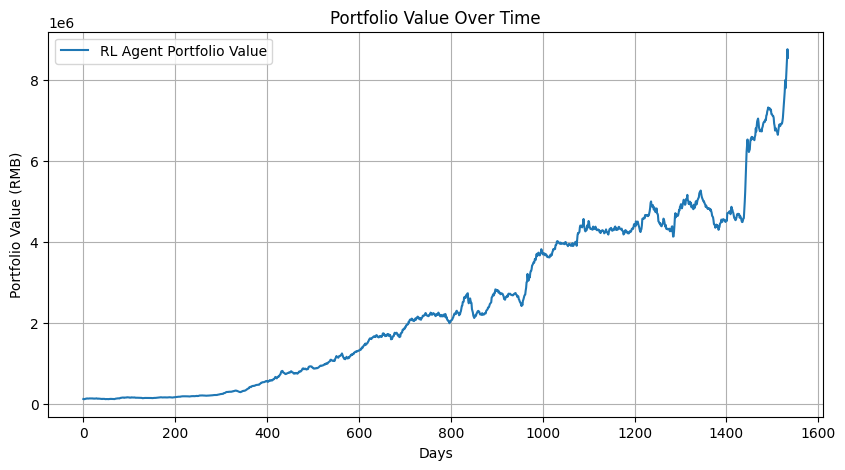

Sharpe Ratio: 0.1974
Sortino Ratio: 0.3347


In [101]:
# === 6. Visualization ===
cumulative_returns = np.cumprod(1 + returns)
portfolio_value = 130000 * cumulative_returns

plt.figure(figsize=(10, 5))
plt.plot(portfolio_value, label="RL Agent Portfolio Value")
plt.xlabel("Days")
plt.ylabel("Portfolio Value (RMB)")
plt.title("Portfolio Value Over Time")
plt.legend()
plt.grid(True)
plt.show()

print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Sortino Ratio: {sortino:.4f}")

In [100]:
model.save("ppo_portfolio_model")
